<a href="https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/colabs/dev2vec_in_lkml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIGNAL*ing* `the temporal dynamics of developer activities` in LKML

##### **Copyright 2022 SRI International.**

This project is under the GPL3 License. 
See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

# 🏃‍♀️ Quickstart

In this notebook, we introduce **dev2vec**, a multi-task learning architecture for identifying and understanding developer interactions. We empirically evaluate our approach on the Linux Kernel, a mature ecosystem with a vibrant community and a wealth of socio-technical developer interactions, utilizing conversations and interactions originating from its Linux Kernel Mailing List (LKML).

## &#9776; Install `needed` libraries

In [1]:
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
try:
  from google.colab import data_table
  # disabling colabs data table formatter
  # as this formatter throws the following warning
  # Warning: Total number of columns (28) exceeds max_columns (20). Falling back to pandas display.
  # data_table.enable_dataframe_formatter()
  data_table.disable_dataframe_formatter()
except Exception:
  print("Launched notebook locally")

## &#9997; Set `needed` configuration

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
# origins of the .csv data files used
# True: originating within the signal-public GitHub repository
# False: need to be downloaded from a provided URL, especially useful if running on Colab
IS_LOCAL_FILE = False

In [7]:
COLUMNS_OF_INTEREST = ['sent_time', 'Code Contribution', 'Knowledge Sharing', 'Patch Posting', 'Progress Control', 
                       'Acknowledgement and Response', 'is_triage', 'is_bug_fix', 'is_controversial']

COLUMNS_OF_INTEREST

['sent_time',
 'Code Contribution',
 'Knowledge Sharing',
 'Patch Posting',
 'Progress Control',
 'Acknowledgement and Response',
 'is_triage',
 'is_bug_fix',
 'is_controversial']

## &#9881; Define `needed` functions

In [8]:
class SequenceDataset(Dataset):

    def __init__(self, data_df, labels_df, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.X = torch.tensor(data_df[self.features].values).float()
        self.y = torch.tensor(labels_df[self.target].values, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        # output: input_data, target_0, target_1, target_2
        return x, self.y[i][0], self.y[i][1], self.y[i][2]

In [9]:
# interpolate data to obtain records equally distant in time
# reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
def interpolate_dataframe(input_df, time_window='1Min', target_column='sent_time'):

    inter_df = input_df.copy().resample(time_window, on=target_column).mean().interpolate().reset_index()

    return inter_df

In [10]:
def rescale_data(df: pd.DataFrame) -> pd.DataFrame:
    """Rescale all features using MinMaxScaler() to same scale, between 0 and 1."""
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(df)

    df_scaled = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

    return df_scaled

In [11]:
# create training and test DataFrames
def split_data(input_df, features_list, targets_list, test_data_size):

    features_df = input_df[features_list].copy()
    targets_df = input_df[targets_list].copy()

    train_data = features_df[:-test_data_size]
    train_labels = targets_df[:-test_data_size]

    test_data = features_df[-test_data_size:]
    test_labels = targets_df[-test_data_size:]

    return train_data, train_labels, test_data, test_labels

In [12]:
def plot_learning_accuracy(output_list):
    x_axis = list(output_list.keys())

    y_triage = list()
    y_bug = list()
    y_controversial = list()

    for k, v in output_list.items():
        y_triage.append(float(v[1]))
        y_bug.append(float(v[2]))
        y_controversial.append(float(v[3]))

    # plottting
    x = x_axis
    fig, ax = plt.subplots(figsize=(10,7))

    line_1, = ax.plot(x, y_triage, label='Triage')
    line_2, = ax.plot(x, y_bug, label='Bugs/Patches')
    line_3, = ax.plot(x, y_controversial, label='Controversial')

    ax.legend()
    # plt.savefig(f'accuracy_20220426-{VERSION}.eps')
    plt.show()

In [13]:
def print_df_info(input_df):
    input_df.info()

In [50]:
def evaluate_model(model, input_dataset):
    losses = list()
    acc_triage = list()
    acc_bug = list()
    acc_controversial = list()

    model.eval()
    for batch in tqdm(input_dataset, ncols=100, desc=f"Input dataset"):
        x, y0, y1, y2 = batch

        # 1. Forward
        # y_hat or logits (l)
        with torch.no_grad():
            l_0, l_1, l_2 = model(x) 

            # 2. Compute the objective function, i.e., J
            J_0 = LOSS_FUNCTION[0](l_0, y0)
            J_1 = LOSS_FUNCTION[0](l_1, y1)
            J_2 = LOSS_FUNCTION[0](l_2, y2)

            # 3. accumulate the partial derivatives of J wrt params
            J = (J_0 + J_1 + J_2)/3.0

            losses.append(J.item())

            acc_0 = y0.eq(l_0.detach().argmax(dim=1)).float().mean()
            acc_1 = y1.eq(l_1.detach().argmax(dim=1)).float().mean()
            acc_2 = y2.eq(l_2.detach().argmax(dim=1)).float().mean()

            acc_triage.append(acc_0)
            acc_bug.append(acc_1)
            acc_controversial.append(acc_2)

    # print(f"testing loss: {torch.tensor(losses).mean():.3f}")
    print(f"\n- accuracy triage: {torch.tensor(acc_triage).mean():.4f}")
    print(f"- accuracy bug: {torch.tensor(acc_bug).mean():.4f}")
    print(f"- accuracy controversial: {torch.tensor(acc_controversial).mean():.4f}")
    print(f"----------")

In [26]:
def stats(input_df):
    tmp_triage = input_df.groupby(input_df.is_triage).size()
    tmp_bug = input_df.groupby(input_df.is_bug_fix).size()
    tmp_controversial = input_df.groupby(input_df.is_controversial).size()
    print(f"{tmp_triage}\n{tmp_bug}\n{tmp_controversial}")

# &#129529; Data cleaning and preparation

In [15]:
ACTIVITIES_FILE = 'activity_triplets_V1_02182022.csv'

In [16]:
# Load preprocessed data and remove unnecessary columns
data_file = f'https://raw.githubusercontent.com/SRI-CSL/signal-public/main/data/{ACTIVITIES_FILE}'

if IS_LOCAL_FILE:
  data_file = f'../data/{ACTIVITIES_FILE}'
else:
  if not os.path.exists(data_file):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy" -O 'activity_triplets_V1_02182022.csv' && rm -rf /tmp/cookies.txt
  else:
    print(f"{ACTIVITIES_FILE} already exists!")

--2022-04-26 18:18:16--  https://docs.google.com/uc?export=download&confirm=&id=1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy
Resolving docs.google.com (docs.google.com)... 142.250.141.100, 142.250.141.138, 142.250.141.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/su9vmrr13pdm44v0b6v4jod264ks32jo/1650997050000/12981205944103091625/*/1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy?e=download [following]
--2022-04-26 18:18:18--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/su9vmrr13pdm44v0b6v4jod264ks32jo/1650997050000/12981205944103091625/*/1BUd2sAUP04Jf1Qnin0uhMeAXaN3gCyTy?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0

### &#128202; Load into DataFrame

In [17]:
ACTIVITY_DF = pd.read_csv(f'./{ACTIVITIES_FILE}', sep='\t')

In [18]:
print_df_info(input_df=ACTIVITY_DF)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27411 entries, 0 to 27410
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    27411 non-null  int64  
 1   Unnamed: 0.1                  27411 non-null  int64  
 2   Unnamed: 0.1.1                27411 non-null  int64  
 3   sender_id                     27411 non-null  int64  
 4   sent_time                     27411 non-null  object 
 5   Code Contribution             27411 non-null  float64
 6   Knowledge Sharing             27411 non-null  float64
 7   Patch Posting                 27411 non-null  float64
 8   Progress Control              27411 non-null  float64
 9   Acknowledgement and Response  27411 non-null  float64
 10  Composite Index               27411 non-null  float64
 11  Rank                          27411 non-null  float64
 12  Status                        27411 non-null  object 
 13  c

In [19]:
# convert 'sent_time' to pandas datetime64 time format
ACTIVITY_DF['sent_time'] = pd.to_datetime(ACTIVITY_DF['sent_time'], utc=True)

# sort the content of the DataFrame by 'sent_time'
ACTIVITY_DF = ACTIVITY_DF.sort_values(by=['sent_time'])

In [20]:
ACTIVITY_DF.describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sender_id,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,Composite Index,Rank,comb_2,comb_3,is_triage,is_bug_fix,is_controversial
count,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000,27411.000000
mean,13705.000000,13705.000000,13705.000000,466.761410,0.249106,0.002233,0.106345,0.032836,0.031109,0.421628,13706.000000,1.308270,3.640911,0.492430,0.375835,0.119332
std,7913.018451,7913.018451,7913.018451,535.754602,0.069497,0.006065,0.054297,0.021204,0.015424,0.095375,7913.018451,0.981164,0.856430,0.499952,0.484346,0.324184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042519,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6852.500000,6852.500000,6852.500000,39.000000,0.260254,0.000728,0.062329,0.024287,0.022645,0.375485,6853.500000,1.000000,3.000000,0.000000,0.000000,0.000000
50%,13705.000000,13705.000000,13705.000000,254.000000,0.269938,0.001165,0.126230,0.029335,0.025764,0.449596,13706.000000,1.000000,4.000000,0.000000,0.000000,0.000000
75%,20557.500000,20557.500000,20557.500000,737.000000,0.278295,0.002111,0.153634,0.034573,0.029421,0.486896,20558.500000,1.000000,4.000000,1.000000,1.000000,0.000000
max,27410.000000,27410.000000,27410.000000,2223.000000,0.317105,0.263279,0.176351,0.158647,0.084617,0.695572,27411.000000,9.000000,9.000000,1.000000,1.000000,1.000000


In [21]:
ACTIVITY_DF.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,sender_id,sent_time,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,...,comb_2,comb_3,is_triage,is_bug_fix,is_controversial,activity_label,project_thread,sendername_thread,triplet_one,triplet_two
24091,24091,24091,24091,0,2020-08-20 09:35:52+00:00,0.262744,0.002416,0.000969,0.032951,0.022704,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
24807,24807,24807,24807,0,2020-08-20 09:35:55+00:00,0.243353,0.001691,0.000833,0.028051,0.021198,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
22403,22403,22403,22403,0,2020-08-20 09:36:02+00:00,0.283699,0.000956,0.000653,0.036240,0.022395,...,2,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
24838,24838,24838,24838,0,2020-08-20 09:36:06+00:00,0.249099,0.000994,0.000669,0.014546,0.022657,...,3,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown
23953,23953,23953,23953,0,2020-08-20 09:36:09+00:00,0.282001,0.001464,0.000143,0.016604,0.023747,...,3,5,0,0,1,Code Contribution,project_name_undefined_unknown,Greg_Kroah-Hartman_unknown,Code_Contribution_project_name_undefined_unknown,Code_Contribution_Greg_Kroah-Hartman_unknown


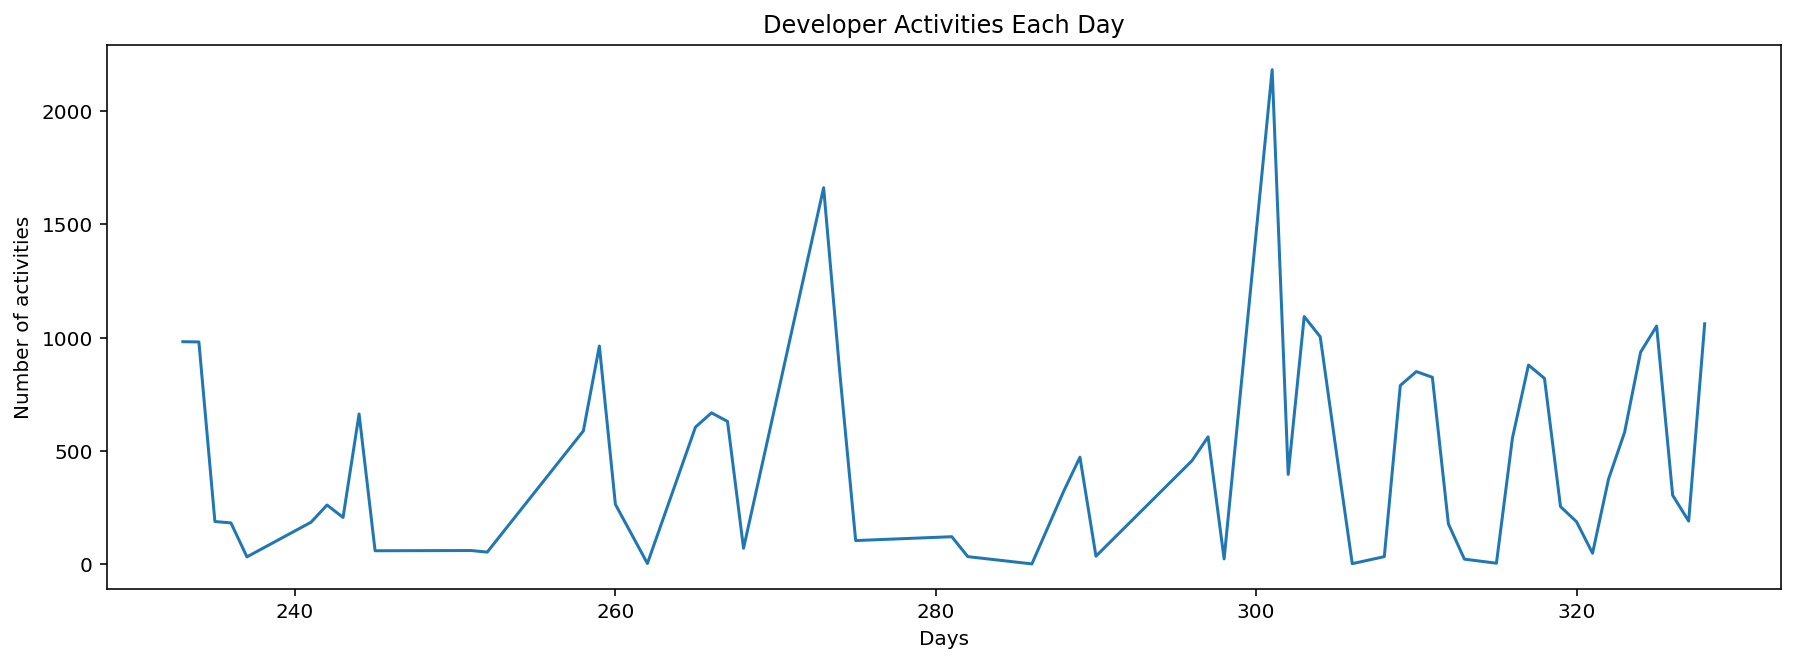

In [22]:
# Plot (visualize) the total number of activities occurring during each day in the August, 2020 - November, 2020 period
tmp_day = ACTIVITY_DF.groupby(ACTIVITY_DF.sent_time.dt.day_of_year).size()
tmp_day.plot(title="Developer Activities Each Day", xlabel="Days", ylabel="Number of activities", figsize=(15, 5))

In the above plot, we can observe that the activities taken by developers can change a lot. While we haven't filtered for specific activity, the fluctuations are still observable.

## &#128368; Time Series Construction

In [23]:
# make a copy of ACTIVITY_DF containing only the COLUMNS_OF_INTEREST
acoi_df = ACTIVITY_DF[COLUMNS_OF_INTEREST].copy().reset_index()
acoi_df.head()

,index,sent_time,Code Contribution,Knowledge Sharing,Patch Posting,Progress Control,Acknowledgement and Response,is_triage,is_bug_fix,is_controversial
0,24091,2020-08-20 09:35:52+00:00,0.262744,0.002416,0.000969,0.032951,0.022704,0,0,1
1,24807,2020-08-20 09:35:55+00:00,0.243353,0.001691,0.000833,0.028051,0.021198,0,0,1
2,22403,2020-08-20 09:36:02+00:00,0.283699,0.000956,0.000653,0.036240,0.022395,0,0,1
3,24838,2020-08-20 09:36:06+00:00,0.249099,0.000994,0.000669,0.014546,0.022657,0,0,1
4,23953,2020-08-20 09:36:09+00:00,0.282001,0.001464,0.000143,0.016604,0.023747,0,0,1


In [24]:
# drop the additionally added 'index' column
acoi_df.drop(['index'], axis=1, inplace=True)

In [25]:
print_df_info(input_df=acoi_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27411 entries, 0 to 27410
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   sent_time                     27411 non-null  datetime64[ns, UTC]
 1   Code Contribution             27411 non-null  float64            
 2   Knowledge Sharing             27411 non-null  float64            
 3   Patch Posting                 27411 non-null  float64            
 4   Progress Control              27411 non-null  float64            
 5   Acknowledgement and Response  27411 non-null  float64            
 6   is_triage                     27411 non-null  int64              
 7   is_bug_fix                    27411 non-null  int64              
 8   is_controversial              27411 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(3)
memory usage: 1.9 MB


In [27]:
stats(input_df=acoi_df)

is_triage
0    13913
1    13498
dtype: int64
is_bug_fix
0    17109
1    10302
dtype: int64
is_controversial
0    24140
1     3271
dtype: int64


In [28]:
last_n = 100

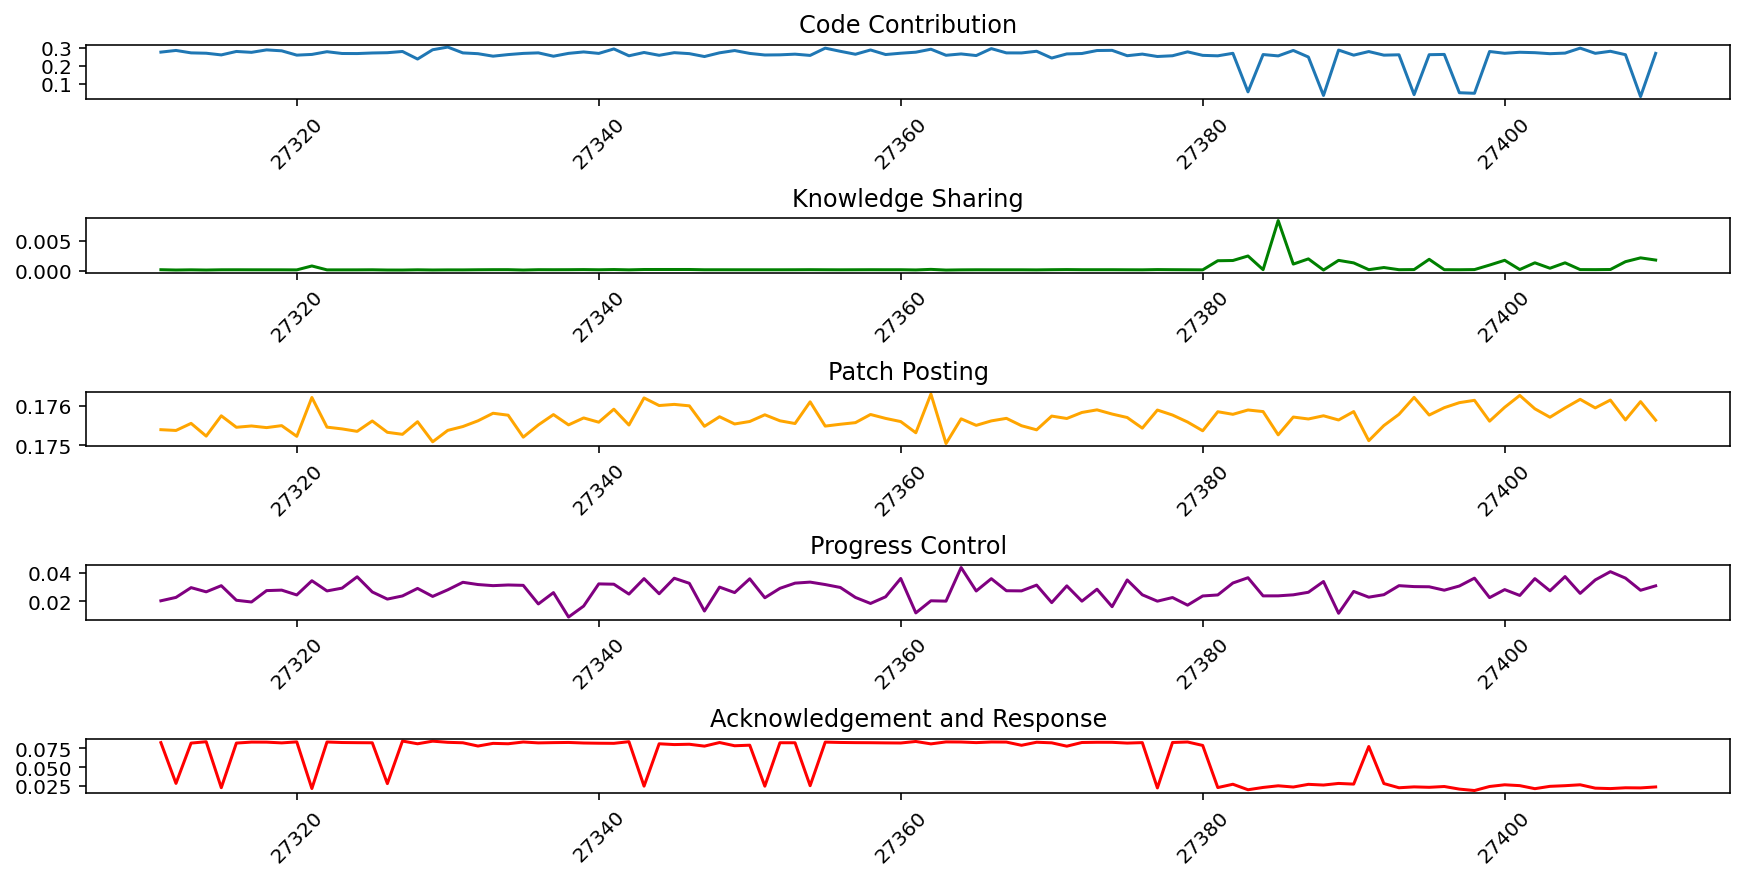

In [29]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(70,40), constrained_layout=True)
acoi_df['Code Contribution'].tail(last_n).plot(ax=axes[0], figsize=(12,6), rot=45, title='Code Contribution')
acoi_df['Knowledge Sharing'].tail(last_n).plot(ax=axes[1], figsize=(12,6), rot=45, title='Knowledge Sharing', color='green')
acoi_df['Patch Posting'].tail(last_n).plot(ax=axes[2], figsize=(12,6), rot=45, title='Patch Posting', color='orange')
acoi_df['Progress Control'].tail(last_n).plot(ax=axes[3], figsize=(12,6), rot=45, title='Progress Control', color='purple')
acoi_df['Acknowledgement and Response'].tail(last_n).plot(ax=axes[4], figsize=(12,6), rot=45, title='Acknowledgement and Response', color='red')
plt.show()

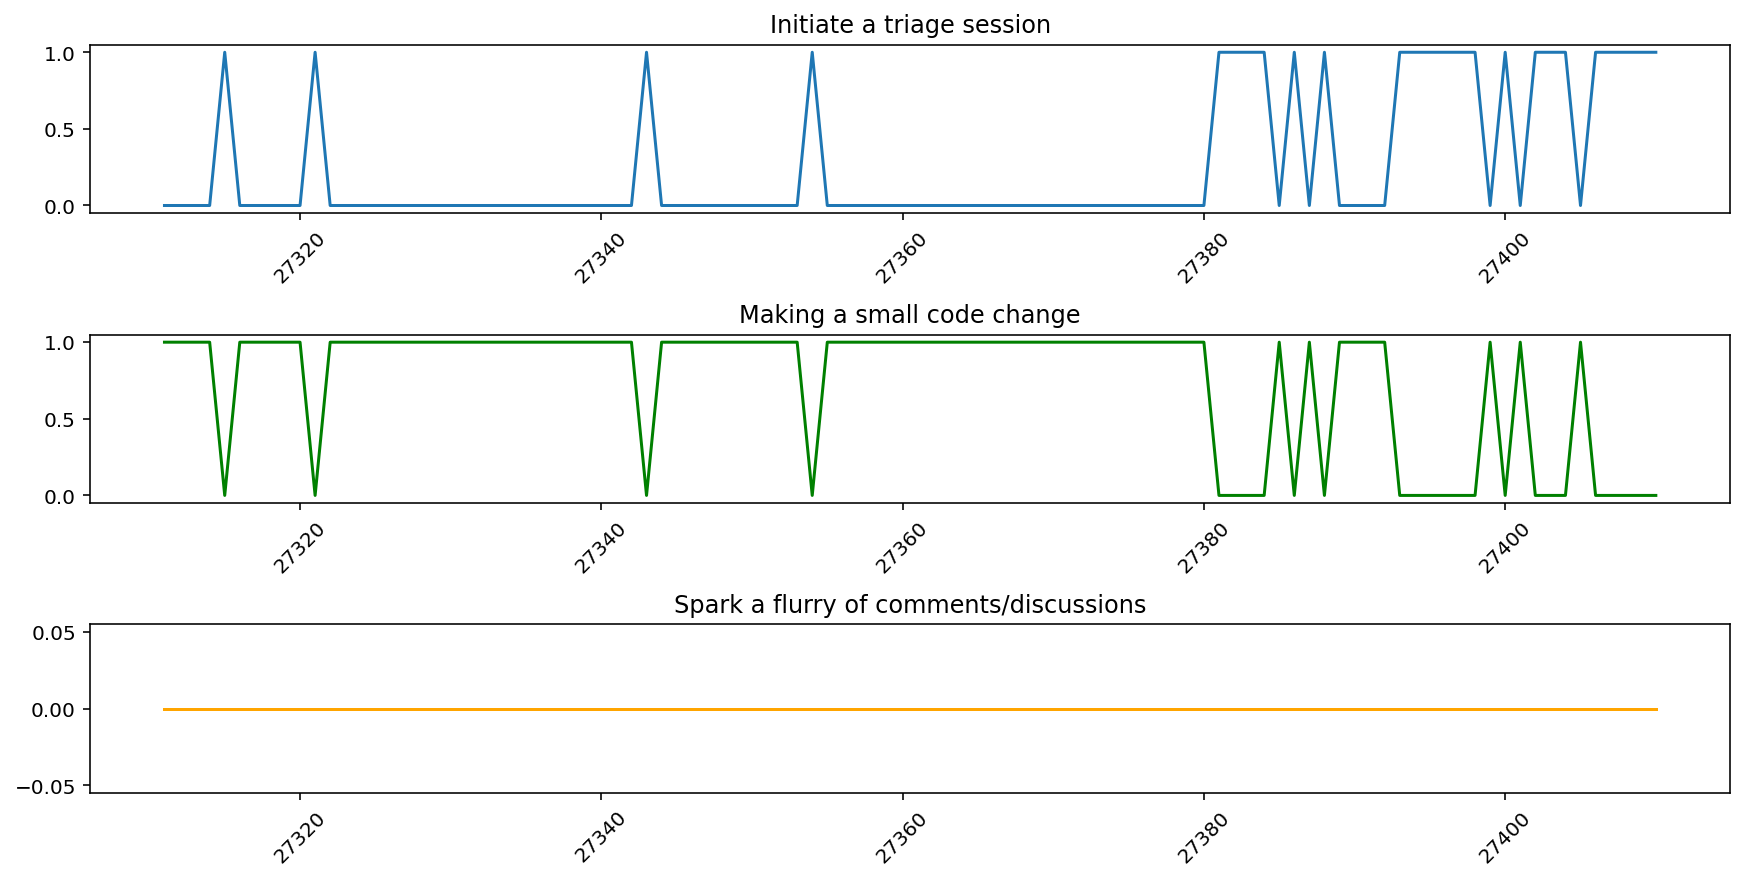

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(70,40), constrained_layout=True)
acoi_df['is_triage'].tail(last_n).plot(ax=axes[0], figsize=(12,6), rot=45, title='Initiate a triage session')
acoi_df['is_bug_fix'].tail(last_n).plot(ax=axes[1], figsize=(12,6), rot=45, title='Making a small code change', color='green')
acoi_df['is_controversial'].tail(last_n).plot(ax=axes[2], figsize=(12,6), rot=45, title='Spark a flurry of comments/discussions', color='orange')
plt.show()

In [31]:
features_of_interest = ['Code Contribution', 'Knowledge Sharing', 'Patch Posting', 'Progress Control', 'Acknowledgement and Response']
targets_of_interest = ['is_triage', 'is_bug_fix', 'is_controversial']

print(f"- We consider {len(features_of_interest)}-features.\n"
      f"- We have {len(targets_of_interest)}-targets.")

- We consider 5-features.
- We have 3-targets.


In [32]:
# train_data, train_labels, test_data, test_labels = split_data(interpolate_df, features_of_interest, targets_of_interest, 300)
# train_data, train_labels, test_data, test_labels = split_data(s, features_of_interest, targets_of_interest, 300)
train_data, train_labels, test_data, test_labels = split_data(acoi_df, features_of_interest, targets_of_interest, 5000)

In [33]:
# scale training and testing data
train_data = rescale_data(train_data)
test_data = rescale_data(test_data)

In [34]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((22411, 5), (22411, 3), (5000, 5), (5000, 3))

In [35]:
stats(train_labels)

is_triage
0    11882
1    10529
dtype: int64
is_bug_fix
0    14070
1     8341
dtype: int64
is_controversial
0    19140
1     3271
dtype: int64


In [36]:
stats(test_labels)

is_triage
0    2031
1    2969
dtype: int64
is_bug_fix
0    3039
1    1961
dtype: int64
is_controversial
0    5000
dtype: int64


# &#129504; `dev2vec`

## &#128640; Hyperparameter setup

In [37]:
VERSION = "V3"
SEQUENCE_LENGTH = 8
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
NO_EPOCHS = 15
WEIGHT_DECAY = 1e-3
LOSS_FUNCTION = [nn.CrossEntropyLoss(), nn.MSELoss()]
MODEL_SAVE_PATH = f"./dev2vec-model-activity-20220426-{VERSION}.pth"

## &#128722; Data Loaders

In [38]:
# creating the training dataset sequence
train_dataset = SequenceDataset(
    data_df=train_data,
    labels_df=train_labels,
    target=targets_of_interest,
    features=features_of_interest,
    sequence_length=SEQUENCE_LENGTH
)

# creating the testing dataset sequence
test_dataset = SequenceDataset(
    data_df=test_data,
    labels_df=test_labels,
    target=targets_of_interest,
    features=features_of_interest,
    sequence_length=SEQUENCE_LENGTH
)

In [39]:
# creating the train and test DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## &#127993; `dev2vec` architecture

Our deep MTL model is sequential in structure. Each fully-connected (FC) model, i.e., **head**, is trained to answer to one of the following questions of interest:

1. Will the next action be a triage action?
2. Will the next action result in a small code change?
3. Will the next action result in a controversial code change, sparking a lot of discussions?

We bring to the attention of the reader that the architecture can be easily extended to accommodate different tasks of interest.

In [40]:
class Dev2Vec(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, device, n_layers=2, dropout=0.15, learning_type="MTL"):
        super(Dev2Vec, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.dropout = dropout
        self.device = device
        self.learning_type = learning_type

        self.initialize_model()

    def initialize_weights(self, m):
        # method constructed according to https://discuss.pytorch.org/t/initialising-weights-in-nn-sequential/76553
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

    def initialize_model(self):
        # LSTM (similar in both STL and MTL taks)
        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.n_hidden,
            num_layers=self.n_layers,
            dropout=self.dropout
        )

        if self.learning_type == "MTL":
            # multi task learning
            self.head_0 = nn.Sequential(
                nn.Linear(in_features=self.n_hidden, out_features=100),
                nn.ReLU(),
                nn.Dropout(p=self.dropout),
                nn.Linear(in_features=100, out_features=2),
                nn.Softmax()
            )

            self.head_0.apply(self.initialize_weights)

            self.head_1 = nn.Sequential(
                nn.Linear(in_features=self.n_hidden, out_features=100),
                nn.ReLU(),
                nn.Dropout(p=self.dropout),
                nn.Linear(in_features=100, out_features=2),
                nn.Softmax()
            )

            self.head_1.apply(self.initialize_weights)

            self.head_2 = nn.Sequential(
                nn.Linear(in_features=self.n_hidden, out_features=100),
                nn.ReLU(),
                nn.Dropout(p=self.dropout),
                nn.Linear(in_features=100, out_features=2),
                nn.Softmax()
            )

            self.head_2.apply(self.initialize_weights)
        else:
            # single task learning
            self.head = nn.Sequential(
                nn.Linear(in_features=self.n_hidden, out_features=100),
                nn.ReLU(),
                nn.Dropout(p=self.dropout),
                nn.Linear(in_features=100, out_features=30),
                nn.ReLU(),
                nn.Dropout(p=self.dropout),
                nn.Linear(in_features=30, out_features=2),
                nn.Softmax()
            )

    def forward(self, sequences):
        h0 = torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(self.device)
        c0 = torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(self.device)

        lstm_out, self.hidden = self.lstm(sequences.view(
            len(sequences), self.seq_len, -1), (h0, c0))
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]

        if self.learning_type == "MTL":
            out_0 = self.head_0(last_time_step)
            out_1 = self.head_1(last_time_step)
            out_2 = self.head_2(last_time_step)

            return out_0, out_1, out_2
        else:
            out = self.head(last_time_step)

            return out

## &#9203; Training `dev2vec` multi-task learning model

In [41]:
def train_dev2vec(model, train_loader, nb_epochs, optimizer, loss_function, model_save_path):
    out_dict = {}
    model.train()

    for epoch in range(nb_epochs):
        losses = list()
        acc_triage = list()
        acc_bug = list()
        acc_controversial = list()

        for batch in tqdm(train_loader, ncols=100, desc=f"Epoch {epoch}"):
            x, y0, y1, y2 = batch

            # 1. Forward
            l_0, l_1, l_2 = model(x)

            # 2. Compute the objective function, i.e., J
            J_0 = loss_function[0](l_0, y0)
            J_1 = loss_function[0](l_1, y1)
            J_2 = loss_function[0](l_2, y2)

            # 3. Clean the gradients
            optimizer.zero_grad()

            # 4. Accumulate the partial derivatives of J w.r.t. params
            J = (J_0 + J_1 + J_2)/3.0
            J.backward()

            # 5. Step in the opposite of the gradient
            optimizer.step()

            # 6. Calculate accuracy
            acc_0 = y0.eq(l_0.detach().argmax(dim=1)).float().mean()
            acc_1 = y1.eq(l_1.detach().argmax(dim=1)).float().mean()
            acc_2 = y2.eq(l_2.detach().argmax(dim=1)).float().mean()

            # 7. Store values
            losses.append(J.item())

            acc_triage.append(acc_0)
            acc_bug.append(acc_1)
            acc_controversial.append(acc_2)

        print(f"- Epoch {epoch:4}", end=" ")
        print(f"loss: {torch.tensor(losses).mean():.4f}", end=" ")
        print(f"acc_triage: {torch.tensor(acc_triage).mean():.4f}", end=" ")
        print(f"acc_bug: {torch.tensor(acc_bug).mean():.4f}", end=" ")
        print(f"acc_controversial: {torch.tensor(acc_controversial).mean():.4f}")

        out_dict[epoch] = [torch.tensor(losses).mean(), torch.tensor(acc_triage).mean(), 
                           torch.tensor(acc_bug).mean(), torch.tensor(acc_controversial).mean()]

    # save model
    torch.save(model.state_dict(), model_save_path)
    print(f"- Model successfully saved at: {model_save_path}")

    return out_dict

In [42]:
model = Dev2Vec(n_features=len(features_of_interest), n_hidden=300, seq_len=SEQUENCE_LENGTH, 
                device=device, learning_type="MTL")
model = model.to(device)
model

Dev2Vec(
  (lstm): LSTM(5, 300, num_layers=2, dropout=0.15)
  (head_0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): Softmax(dim=None)
  )
  (head_1): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): Softmax(dim=None)
  )
  (head_2): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): Softmax(dim=None)
  )
)

In [43]:
# Adam optimizer with L2 regularization in addition to nn.Dropout()-layer in the model
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [44]:
out_list = train_dev2vec(model, train_loader, NO_EPOCHS, optimizer, LOSS_FUNCTION, MODEL_SAVE_PATH)

Epoch 0: 100%|██████████████████████████████████████████████████| 5603/5603 [02:08<00:00, 43.76it/s]


- Epoch    0 loss: 0.5925 acc_triage: 0.5720 acc_bug: 0.6409 acc_controversial: 0.8540


Epoch 1: 100%|██████████████████████████████████████████████████| 5603/5603 [02:12<00:00, 42.16it/s]


- Epoch    1 loss: 0.5817 acc_triage: 0.6047 acc_bug: 0.6540 acc_controversial: 0.8541


Epoch 2: 100%|██████████████████████████████████████████████████| 5603/5603 [02:13<00:00, 41.99it/s]


- Epoch    2 loss: 0.5746 acc_triage: 0.6171 acc_bug: 0.6596 acc_controversial: 0.8578


Epoch 3: 100%|██████████████████████████████████████████████████| 5603/5603 [02:09<00:00, 43.32it/s]


- Epoch    3 loss: 0.5728 acc_triage: 0.6220 acc_bug: 0.6598 acc_controversial: 0.8579


Epoch 4: 100%|██████████████████████████████████████████████████| 5603/5603 [02:06<00:00, 44.21it/s]


- Epoch    4 loss: 0.5706 acc_triage: 0.6224 acc_bug: 0.6621 acc_controversial: 0.8575


Epoch 5: 100%|██████████████████████████████████████████████████| 5603/5603 [02:10<00:00, 42.91it/s]


- Epoch    5 loss: 0.5696 acc_triage: 0.6289 acc_bug: 0.6669 acc_controversial: 0.8563


Epoch 6: 100%|██████████████████████████████████████████████████| 5603/5603 [02:08<00:00, 43.73it/s]


- Epoch    6 loss: 0.5691 acc_triage: 0.6286 acc_bug: 0.6610 acc_controversial: 0.8576


Epoch 7: 100%|██████████████████████████████████████████████████| 5603/5603 [02:07<00:00, 43.83it/s]


- Epoch    7 loss: 0.5678 acc_triage: 0.6271 acc_bug: 0.6699 acc_controversial: 0.8570


Epoch 8: 100%|██████████████████████████████████████████████████| 5603/5603 [02:07<00:00, 43.82it/s]


- Epoch    8 loss: 0.5672 acc_triage: 0.6335 acc_bug: 0.6681 acc_controversial: 0.8592


Epoch 9: 100%|██████████████████████████████████████████████████| 5603/5603 [02:08<00:00, 43.64it/s]


- Epoch    9 loss: 0.5678 acc_triage: 0.6288 acc_bug: 0.6654 acc_controversial: 0.8592


Epoch 10: 100%|█████████████████████████████████████████████████| 5603/5603 [02:11<00:00, 42.46it/s]


- Epoch   10 loss: 0.5668 acc_triage: 0.6291 acc_bug: 0.6705 acc_controversial: 0.8592


Epoch 11: 100%|█████████████████████████████████████████████████| 5603/5603 [02:11<00:00, 42.52it/s]


- Epoch   11 loss: 0.5672 acc_triage: 0.6323 acc_bug: 0.6695 acc_controversial: 0.8587


Epoch 12: 100%|█████████████████████████████████████████████████| 5603/5603 [02:11<00:00, 42.74it/s]


- Epoch   12 loss: 0.5648 acc_triage: 0.6336 acc_bug: 0.6749 acc_controversial: 0.8579


Epoch 13: 100%|█████████████████████████████████████████████████| 5603/5603 [02:13<00:00, 42.10it/s]


- Epoch   13 loss: 0.5673 acc_triage: 0.6305 acc_bug: 0.6710 acc_controversial: 0.8587


Epoch 14: 100%|█████████████████████████████████████████████████| 5603/5603 [02:13<00:00, 41.87it/s]


- Epoch   14 loss: 0.5654 acc_triage: 0.6347 acc_bug: 0.6712 acc_controversial: 0.8588
- Model successfully saved at: ./dev2vec-model-activity-20220426-V3.pth


## &#129514; Testing `dev2vec` 

In [45]:
# Load the trained model
model = Dev2Vec(n_features=len(features_of_interest), n_hidden=300, seq_len=SEQUENCE_LENGTH, 
                device=device, learning_type="MTL")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model = model.to(device)
model

Dev2Vec(
  (lstm): LSTM(5, 300, num_layers=2, dropout=0.15)
  (head_0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): Softmax(dim=None)
  )
  (head_1): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): Softmax(dim=None)
  )
  (head_2): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=100, out_features=2, bias=True)
    (4): Softmax(dim=None)
  )
)

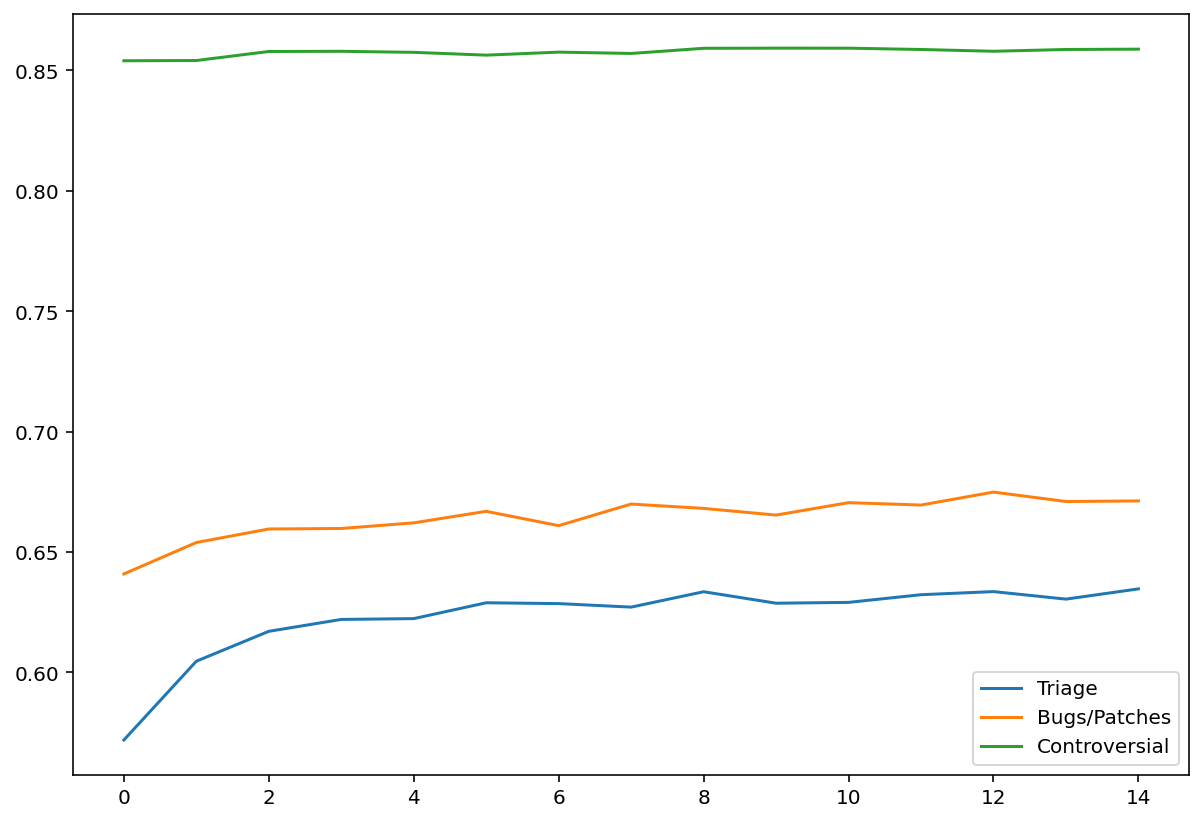

In [46]:
plot_learning_accuracy(output_list=out_list)

In [47]:
x_axis = list(out_list.keys())
loss_vals = list()
for k, v in out_list.items():
    loss_vals.append(float(v[0]))

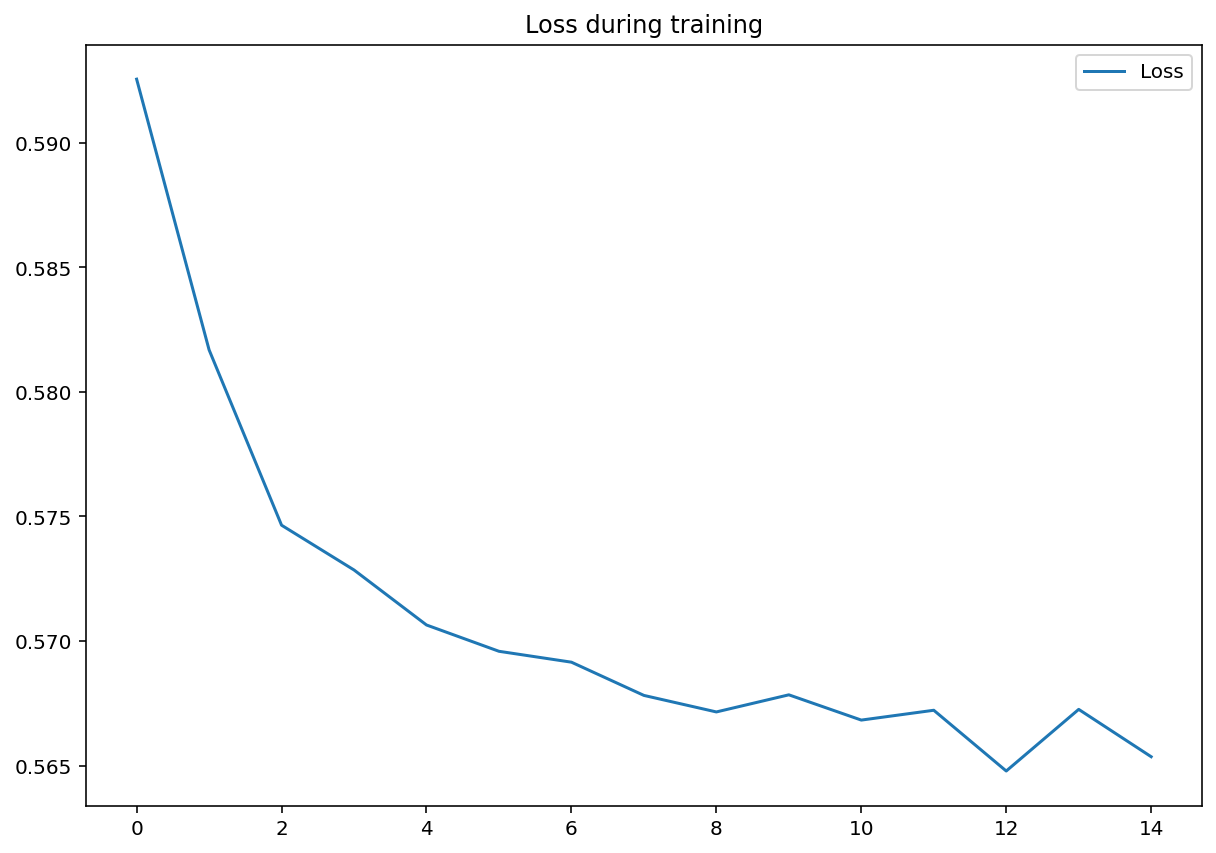

In [48]:
plt.rcParams["figure.figsize"] = (10, 7)
plt.plot(x_axis, loss_vals, label='Loss')
plt.title('Loss during training')
plt.legend(loc="upper right")
# plt.savefig(f'loss_20220426-{VERSION}.eps')

In [51]:
evaluate_model(model=model, input_dataset=train_loader)

Input dataset: 100%|███████████████████████████████████████████| 5603/5603 [00:21<00:00, 264.02it/s]


- accuracy triage: 0.6335
- accuracy bug: 0.6728
- accuracy controversial: 0.8586
----------


In [52]:
evaluate_model(model=model, input_dataset=test_loader)

Input dataset: 100%|███████████████████████████████████████████| 1250/1250 [00:06<00:00, 207.89it/s]


- accuracy triage: 0.7198
- accuracy bug: 0.7608
- accuracy controversial: 0.9410
----------


## &#127939; Run the `dev2vec` Model

The model expects a Torch tensor of the size [batch_size, sequence_length, feature_length], e.g., [1, 4, 5]

In [54]:
def yes_no_transform(input_val):
    return 'Yes' if input_val == 1 else 'No'

In [94]:
def dev2vec_predict(model, input_sequence):
    # model: trained and loaded dev2vec model
    # input_sequence: Torch tensor of the sequence to test in the form [batch_size, sequence_length, feature_length]

    # setting the model in the eval mode
    model.eval()

    with torch.no_grad():
        l_0, l_1, l_2 = model(input_sequence)

    return yes_no_transform(l_0.detach().argmax(dim=1).item()), yes_no_transform(l_1.detach().argmax(dim=1).item()), yes_no_transform(l_2.detach().argmax(dim=1).item())

In [95]:
sample_input = torch.Tensor([[[0.8415, 0.0107, 0.4761, 0.1569, 0.1810],
         [0.8194, 0.0092, 0.4548, 0.2611, 0.1461],
         [0.8759, 0.0158, 0.4848, 0.8290, 0.1380],
         [0.8037, 0.0051, 0.4835, 0.8915, 0.1410],
         [0.7971, 0.0045, 0.5133, 0.7913, 0.1031],
         [0.8281, 0.0056, 0.4802, 0.1520, 0.1160],
         [0.7875, 0.0072, 0.4776, 0.1354, 0.1230],
         [0.8854, 0.0029, 0.4751, 0.2020, 0.2016]]])

# expected output: 1, 0, 0
pred_0, pred_1, pred_2 = dev2vec_predict(model=model, input_sequence=sample_input)
print(f"Initiate a triage session: {pred_0} \tMaking a small code change: {pred_1} \tSpark a flurry of comments/discussions: {pred_2}")

Initiate a triage session: Yes 	Making a small code change: No 	Spark a flurry of comments/discussions: No
